In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import torch
print(torch.cuda.is_available()) # True
print(torch.cuda.device_count()) # 1
print(torch.cuda.current_device()) # 0
print(torch.cuda.device(0)) # <torch.cuda.device at 0x7efce0b03be0>
print(torch.cuda.get_device_name(0)) # 'GeForce GTX 950M'

True
1
0
NVIDIA TITAN Xp


In [4]:
import sys
sys.path.append("../../..")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-22 16:28:21.288043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 16:28:22.800524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-22 16:28:22.800658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-22 16:28:22.800674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [7]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
# loader.print_readme()

In [9]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [10]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [11]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [12]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [13]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [14]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [15]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [16]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [17]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [18]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [19]:
# Variables to reuse
model_dim = 10
model_epc = 500

# Reducing with Convolutional Topological Autoencoders (L=0)

In [21]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:1303.6122, Loss-ae:1303.6122, Loss-topo:1088.6762
Epoch:2, P:None, Loss:719.9117, Loss-ae:719.9117, Loss-topo:1316.9734
Epoch:3, P:None, Loss:430.2899, Loss-ae:430.2899, Loss-topo:4742.7050
Epoch:4, P:None, Loss:320.3979, Loss-ae:320.3979, Loss-topo:8258.6892
Epoch:5, P:None, Loss:288.4528, Loss-ae:288.4528, Loss-topo:10404.9185
Epoch:6, P:None, Loss:267.1547, Loss-ae:267.1547, Loss-topo:12200.7412
Epoch:7, P:None, Loss:257.1644, Loss-ae:257.1644, Loss-topo:14078.3126
Epoch:8, P:None, Loss:242.4408, Loss-ae:242.4408, Loss-topo:20903.3583
Epoch:9, P:None, Loss:224.1166, Loss-ae:224.1166, Loss-topo:19397.2866
Epoch:10, P:None, Loss:202.6070, Loss-ae:202.6070, Loss-topo:22299.3811
Epoch:11, P:None, Loss:192.4088, Loss-ae:192.4088, Loss-topo:27197.1869
Epoch:12, P:None, Loss:184.3026, Loss-ae:184.3026, Loss-topo:29094.3256
Epoch:13, P:None, Loss:176.3881, Loss-ae:176.3881, Loss-topo:31618.9939
Epoch:14, P:None, Loss:168.1919, Loss-ae:168.1919, Loss-topo:35215.4099
Epo

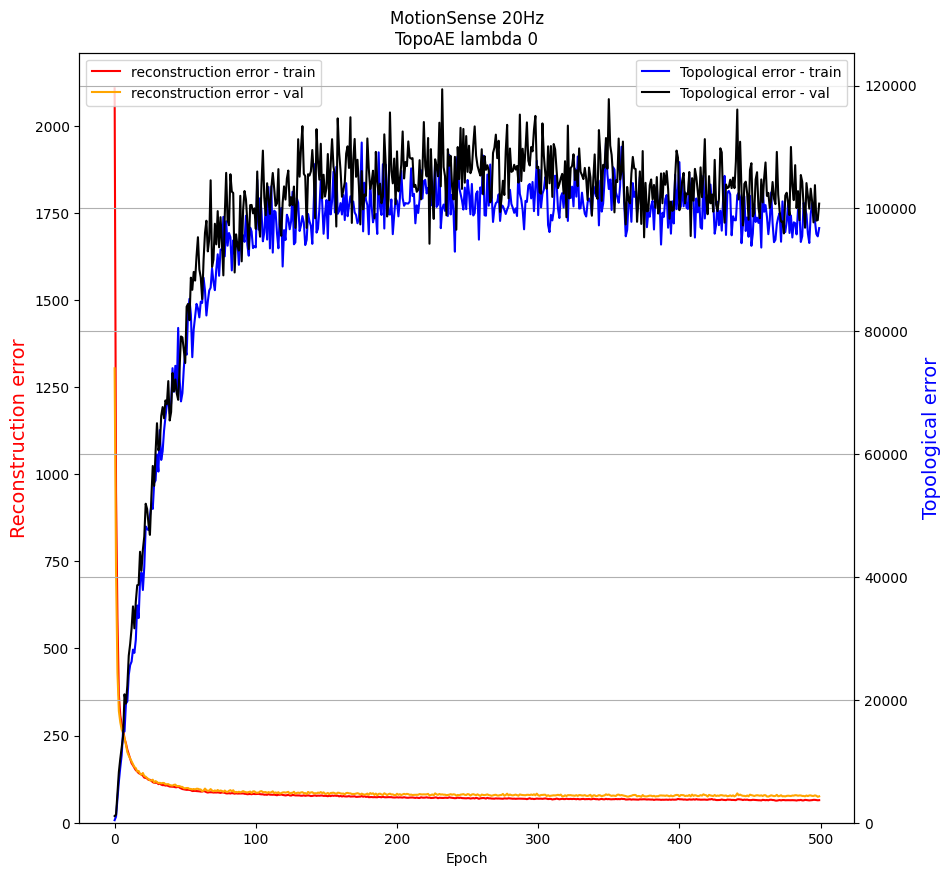

In [22]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [23]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [24]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [25]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8753921568627451,
 'RF-F1': 0.8753022893951268,
 'SVC-ACC': 0.8705882352941177,
 'SVC-F1': 0.8734563505250043,
 'KNN-ACC': 0.8382352941176471,
 'KNN-F1': 0.8391328202702889}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


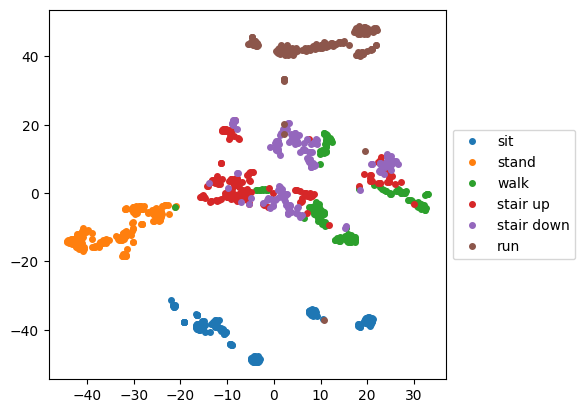

In [26]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [27]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:1318.4461, Loss-ae:1149.6464, Loss-topo:168.7997
Epoch:2, P:None, Loss:839.5023, Loss-ae:805.2504, Loss-topo:34.2518
Epoch:3, P:None, Loss:803.6785, Loss-ae:774.4779, Loss-topo:29.2007
Epoch:4, P:None, Loss:805.3915, Loss-ae:783.0902, Loss-topo:22.3013
Epoch:5, P:None, Loss:782.6503, Loss-ae:761.7149, Loss-topo:20.9354
Epoch:6, P:None, Loss:782.8322, Loss-ae:759.2033, Loss-topo:23.6288
Epoch:7, P:None, Loss:726.9719, Loss-ae:688.1277, Loss-topo:38.8441
Epoch:8, P:None, Loss:594.2965, Loss-ae:538.8371, Loss-topo:55.4594
Epoch:9, P:None, Loss:514.1101, Loss-ae:458.7969, Loss-topo:55.3132
Epoch:10, P:None, Loss:466.8373, Loss-ae:433.1794, Loss-topo:33.6578
Epoch:11, P:None, Loss:461.8720, Loss-ae:435.7462, Loss-topo:26.1259
Epoch:12, P:None, Loss:440.7387, Loss-ae:419.0694, Loss-topo:21.6694
Epoch:13, P:None, Loss:439.3084, Loss-ae:420.2580, Loss-topo:19.0504
Epoch:14, P:None, Loss:427.6002, Loss-ae:411.4184, Loss-topo:16.1818
Epoch:15, P:None, Loss:445.1342, Loss-ae

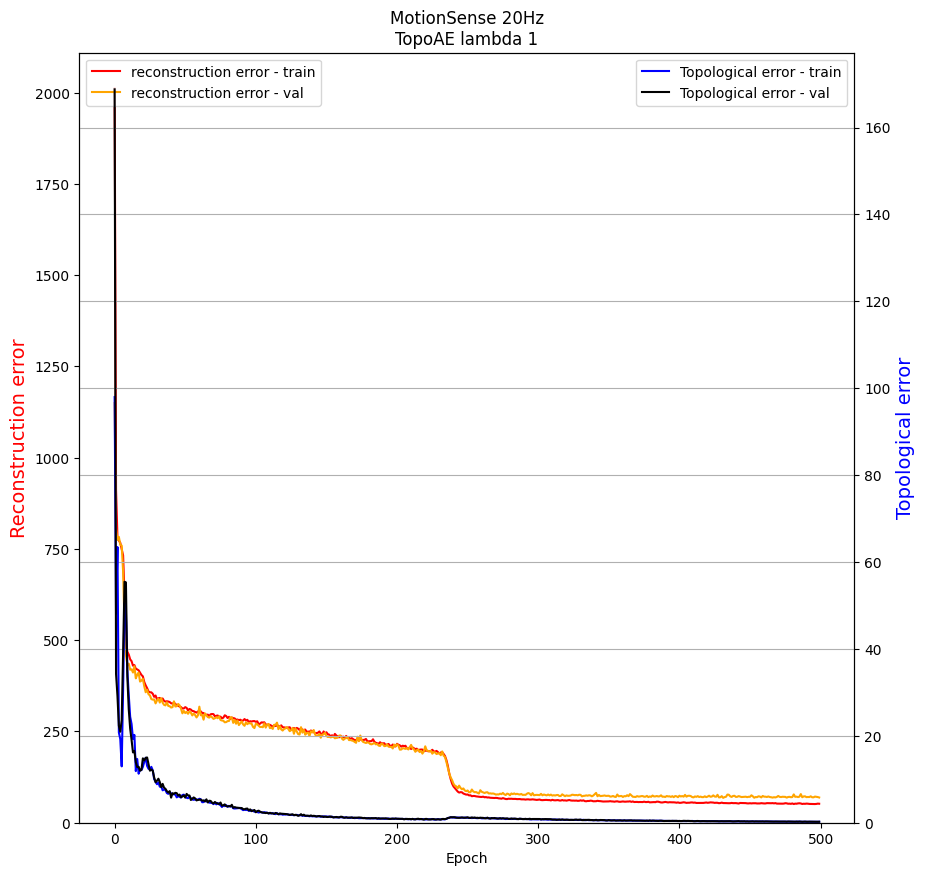

In [28]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [29]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [30]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [31]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8769607843137255,
 'RF-F1': 0.8760391976216717,
 'SVC-ACC': 0.8803921568627451,
 'SVC-F1': 0.879101057806252,
 'KNN-ACC': 0.8529411764705882,
 'KNN-F1': 0.8520823273734297}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


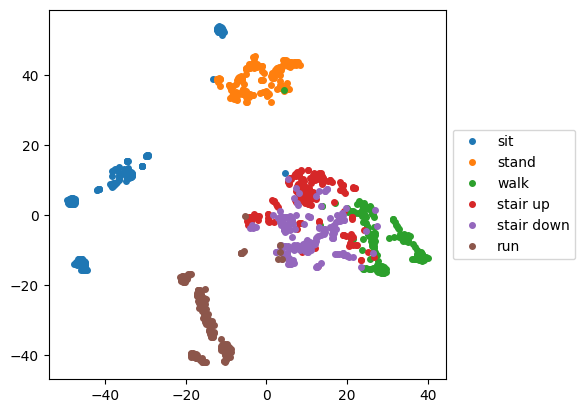

In [32]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [33]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:1589.0767, Loss-ae:1493.6658, Loss-topo:19.0822
Epoch:2, P:None, Loss:916.7171, Loss-ae:821.7559, Loss-topo:18.9922
Epoch:3, P:None, Loss:810.9130, Loss-ae:766.2132, Loss-topo:8.9400
Epoch:4, P:None, Loss:802.2646, Loss-ae:763.1904, Loss-topo:7.8148
Epoch:5, P:None, Loss:802.8222, Loss-ae:774.3626, Loss-topo:5.6919
Epoch:6, P:None, Loss:762.3517, Loss-ae:734.4547, Loss-topo:5.5794
Epoch:7, P:None, Loss:751.3187, Loss-ae:730.6447, Loss-topo:4.1348
Epoch:8, P:None, Loss:746.8553, Loss-ae:726.7658, Loss-topo:4.0179
Epoch:9, P:None, Loss:699.2293, Loss-ae:674.7685, Loss-topo:4.8922
Epoch:10, P:None, Loss:671.0590, Loss-ae:644.2939, Loss-topo:5.3530
Epoch:11, P:None, Loss:591.8438, Loss-ae:557.2254, Loss-topo:6.9237
Epoch:12, P:None, Loss:516.1244, Loss-ae:471.5895, Loss-topo:8.9070
Epoch:13, P:None, Loss:475.7378, Loss-ae:440.3458, Loss-topo:7.0784
Epoch:14, P:None, Loss:421.3535, Loss-ae:386.7660, Loss-topo:6.9175
Epoch:15, P:None, Loss:420.5158, Loss-ae:387.9254, Lo

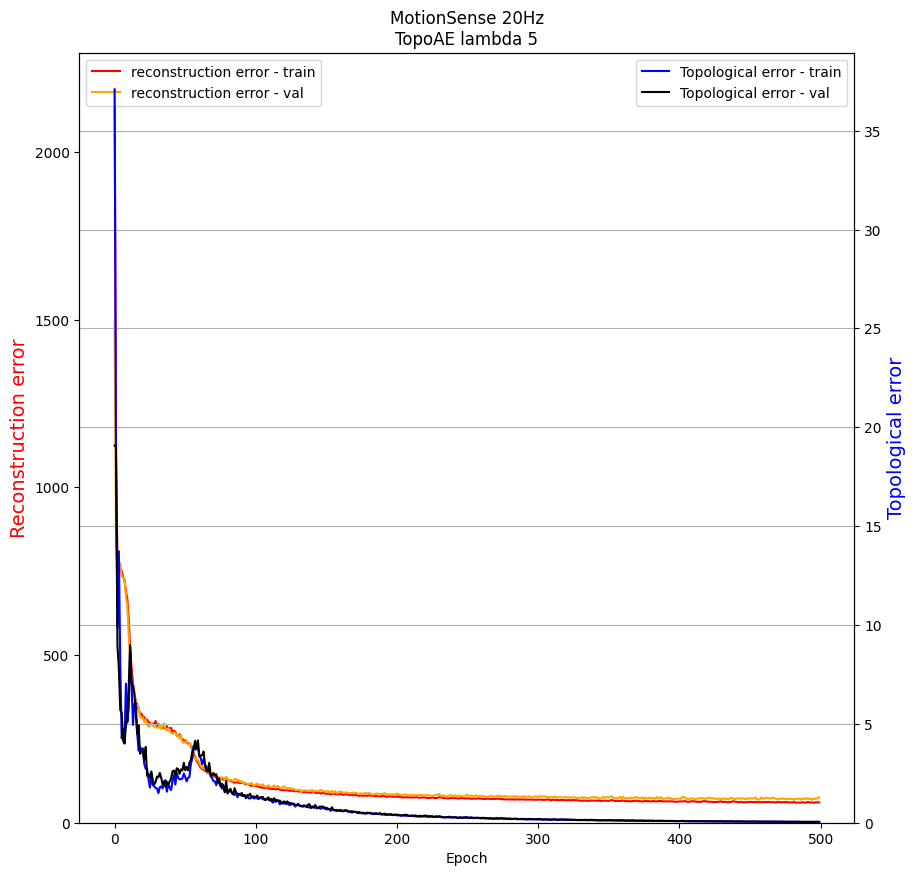

In [34]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [35]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [36]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [37]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8897058823529411,
 'RF-F1': 0.8900306937110942,
 'SVC-ACC': 0.8735294117647059,
 'SVC-F1': 0.8731128249871467,
 'KNN-ACC': 0.8284313725490197,
 'KNN-F1': 0.827451965367658}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


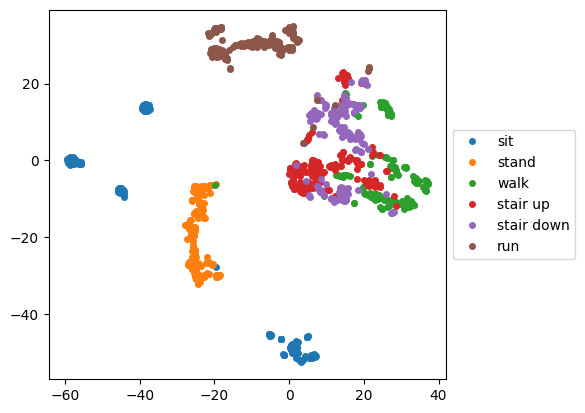

In [38]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [39]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:2559.5926, Loss-ae:2558.6703, Loss-topo:0.0922
Epoch:2, P:None, Loss:2074.3397, Loss-ae:2029.0567, Loss-topo:4.5283
Epoch:3, P:None, Loss:1301.0327, Loss-ae:1228.7412, Loss-topo:7.2292
Epoch:4, P:None, Loss:908.5317, Loss-ae:866.3059, Loss-topo:4.2226
Epoch:5, P:None, Loss:803.3520, Loss-ae:756.9865, Loss-topo:4.6366
Epoch:6, P:None, Loss:791.5228, Loss-ae:760.8670, Loss-topo:3.0656
Epoch:7, P:None, Loss:767.7452, Loss-ae:740.1650, Loss-topo:2.7580
Epoch:8, P:None, Loss:764.6505, Loss-ae:749.5712, Loss-topo:1.5079
Epoch:9, P:None, Loss:740.5798, Loss-ae:724.6750, Loss-topo:1.5905
Epoch:10, P:None, Loss:757.6754, Loss-ae:746.1574, Loss-topo:1.1518
Epoch:11, P:None, Loss:729.7054, Loss-ae:716.1193, Loss-topo:1.3586
Epoch:12, P:None, Loss:704.6448, Loss-ae:693.1216, Loss-topo:1.1523
Epoch:13, P:None, Loss:666.0476, Loss-ae:651.7700, Loss-topo:1.4278
Epoch:14, P:None, Loss:672.2538, Loss-ae:662.9831, Loss-topo:0.9271
Epoch:15, P:None, Loss:682.3880, Loss-ae:669.0473, 

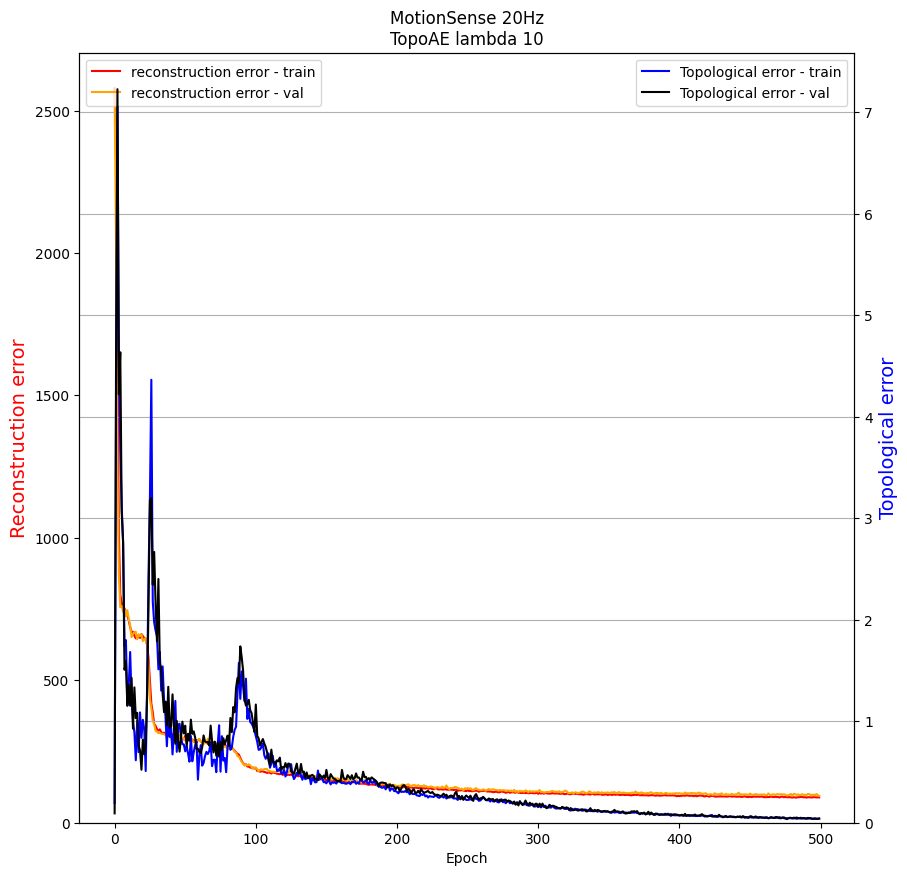

In [40]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [41]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [42]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [43]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8573529411764707,
 'RF-F1': 0.8578386904009824,
 'SVC-ACC': 0.8941176470588236,
 'SVC-F1': 0.8944317905961403,
 'KNN-ACC': 0.8313725490196079,
 'KNN-F1': 0.8307942537536497}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


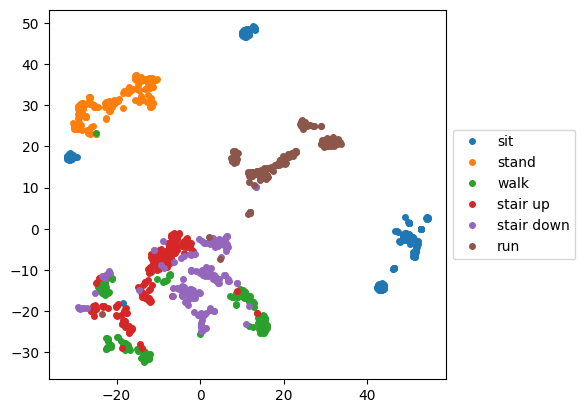

In [44]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [45]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:2531.8765, Loss-ae:2529.3276, Loss-topo:0.0255
Epoch:2, P:None, Loss:1615.7872, Loss-ae:1434.8995, Loss-topo:1.8089
Epoch:3, P:None, Loss:921.1931, Loss-ae:819.6440, Loss-topo:1.0155
Epoch:4, P:None, Loss:859.9910, Loss-ae:791.3429, Loss-topo:0.6865
Epoch:5, P:None, Loss:795.2015, Loss-ae:758.8186, Loss-topo:0.3638
Epoch:6, P:None, Loss:755.6555, Loss-ae:734.9362, Loss-topo:0.2072
Epoch:7, P:None, Loss:782.0926, Loss-ae:718.7706, Loss-topo:0.6332
Epoch:8, P:None, Loss:720.7206, Loss-ae:693.0542, Loss-topo:0.2767
Epoch:9, P:None, Loss:739.6504, Loss-ae:701.1671, Loss-topo:0.3848
Epoch:10, P:None, Loss:691.3226, Loss-ae:671.0537, Loss-topo:0.2027
Epoch:11, P:None, Loss:693.4195, Loss-ae:674.9952, Loss-topo:0.1842
Epoch:12, P:None, Loss:715.6953, Loss-ae:698.3377, Loss-topo:0.1736
Epoch:13, P:None, Loss:723.9672, Loss-ae:704.5937, Loss-topo:0.1937
Epoch:14, P:None, Loss:719.1197, Loss-ae:698.4951, Loss-topo:0.2062
Epoch:15, P:None, Loss:684.0084, Loss-ae:669.1196, Lo

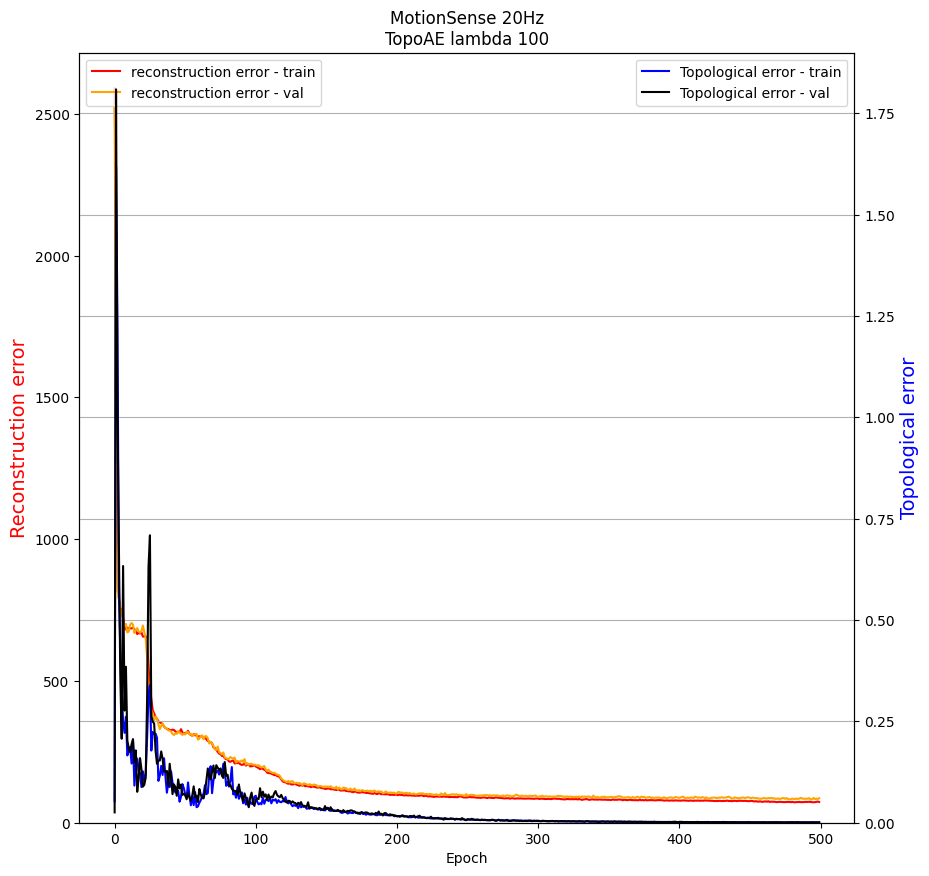

In [46]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [47]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [48]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [49]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8512745098039215,
 'RF-F1': 0.8498138562739472,
 'SVC-ACC': 0.8637254901960785,
 'SVC-F1': 0.863240494467137,
 'KNN-ACC': 0.8127450980392157,
 'KNN-F1': 0.8105069993582864}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


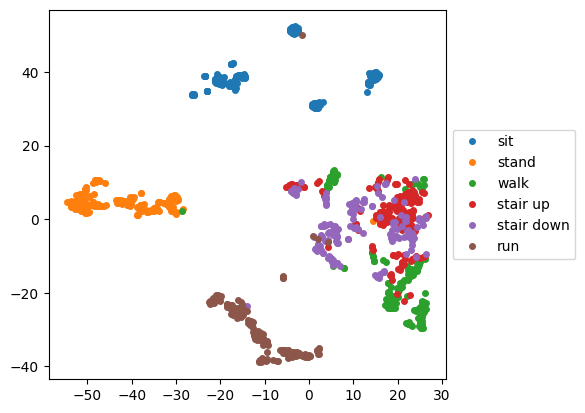

In [50]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=0.1)

In [51]:
model_lam = 0.1
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:2255.6690, Loss-ae:2248.2079, Loss-topo:74.6119
Epoch:2, P:None, Loss:1540.2604, Loss-ae:1521.5342, Loss-topo:187.2622
Epoch:3, P:None, Loss:653.0771, Loss-ae:616.4248, Loss-topo:366.5235
Epoch:4, P:None, Loss:487.7406, Loss-ae:451.7340, Loss-topo:360.0663
Epoch:5, P:None, Loss:389.7125, Loss-ae:349.5834, Loss-topo:401.2915
Epoch:6, P:None, Loss:351.9443, Loss-ae:323.5489, Loss-topo:283.9545
Epoch:7, P:None, Loss:336.2669, Loss-ae:313.8638, Loss-topo:224.0311
Epoch:8, P:None, Loss:337.1413, Loss-ae:317.9858, Loss-topo:191.5549
Epoch:9, P:None, Loss:304.4382, Loss-ae:287.8114, Loss-topo:166.2684
Epoch:10, P:None, Loss:307.7944, Loss-ae:293.7502, Loss-topo:140.4421
Epoch:11, P:None, Loss:297.0487, Loss-ae:282.7788, Loss-topo:142.6986
Epoch:12, P:None, Loss:288.8845, Loss-ae:277.1842, Loss-topo:117.0029
Epoch:13, P:None, Loss:287.8357, Loss-ae:274.3665, Loss-topo:134.6927
Epoch:14, P:None, Loss:285.0647, Loss-ae:271.1520, Loss-topo:139.1265
Epoch:15, P:None, Loss:265

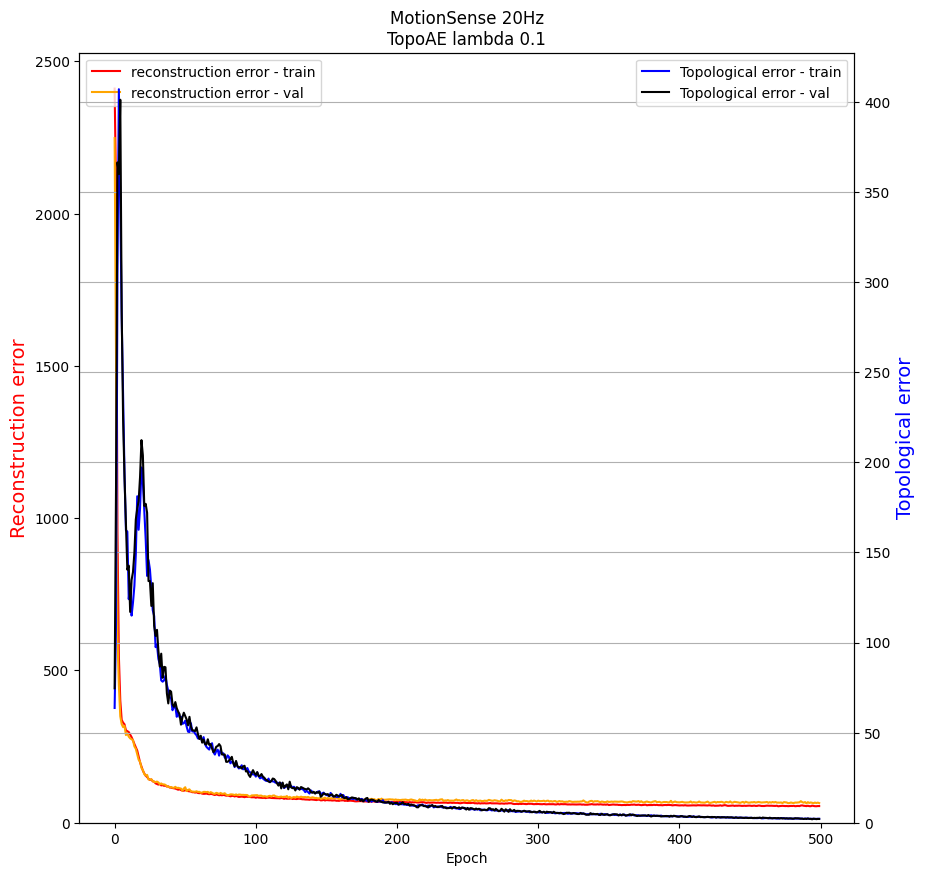

In [52]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [53]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [54]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [55]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8795098039215686,
 'RF-F1': 0.8789835314714459,
 'SVC-ACC': 0.8950980392156863,
 'SVC-F1': 0.895682469668077,
 'KNN-ACC': 0.8607843137254902,
 'KNN-F1': 0.8601658289929981}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


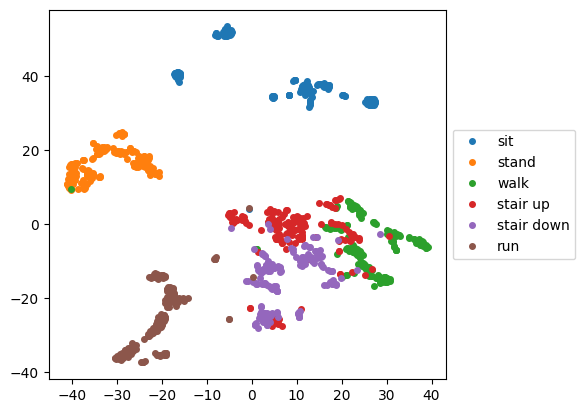

In [56]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=0.01)

In [57]:
model_lam = 0.01
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:2237.2676, Loss-ae:2235.5632, Loss-topo:170.4397
Epoch:2, P:None, Loss:1567.0067, Loss-ae:1559.3438, Loss-topo:766.2854
Epoch:3, P:None, Loss:632.8164, Loss-ae:612.4827, Loss-topo:2033.3706
Epoch:4, P:None, Loss:499.5309, Loss-ae:478.1037, Loss-topo:2142.7129
Epoch:5, P:None, Loss:479.6552, Loss-ae:464.8394, Loss-topo:1481.5731
Epoch:6, P:None, Loss:455.7004, Loss-ae:442.4633, Loss-topo:1323.7053
Epoch:7, P:None, Loss:449.3700, Loss-ae:437.5400, Loss-topo:1183.0001
Epoch:8, P:None, Loss:423.8922, Loss-ae:414.3526, Loss-topo:953.9592
Epoch:9, P:None, Loss:401.5622, Loss-ae:392.1428, Loss-topo:941.9487
Epoch:10, P:None, Loss:405.6543, Loss-ae:396.2326, Loss-topo:942.1650
Epoch:11, P:None, Loss:395.2919, Loss-ae:387.2519, Loss-topo:804.0037
Epoch:12, P:None, Loss:397.4692, Loss-ae:388.5161, Loss-topo:895.3105
Epoch:13, P:None, Loss:389.9406, Loss-ae:381.5795, Loss-topo:836.1162
Epoch:14, P:None, Loss:399.6580, Loss-ae:391.6271, Loss-topo:803.0851
Epoch:15, P:None, Lo

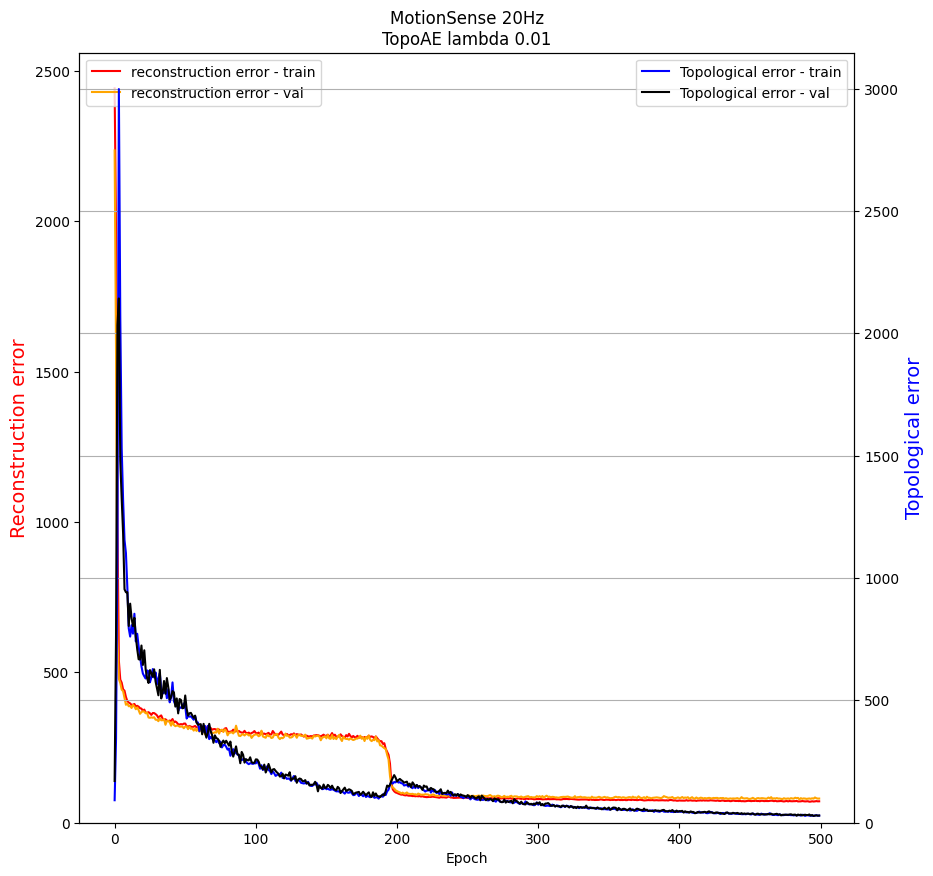

In [58]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [59]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [60]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [61]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8762745098039216,
 'RF-F1': 0.8746800786112653,
 'SVC-ACC': 0.8647058823529412,
 'SVC-F1': 0.864893120204271,
 'KNN-ACC': 0.8372549019607843,
 'KNN-F1': 0.8365250502837182}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


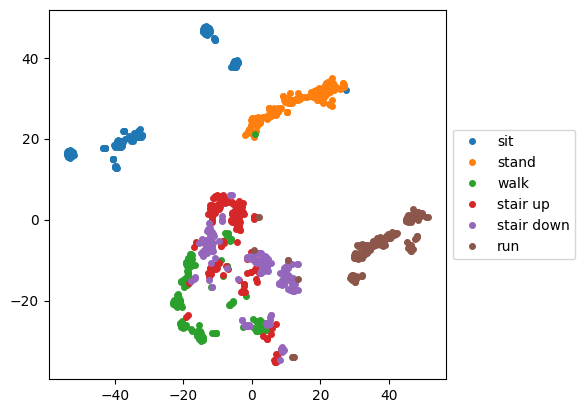

In [62]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)